In [14]:
import math
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from statistics import mean

In [3]:
rdd=sc.textFile('s3://mukuawsproject/DBPedia.csv')

In [4]:
rdd=rdd.map(lambda x:x.split(',')).cache()

In [5]:
rddlatlon=rdd.map(lambda x:(int(x[0]),float(x[1]),float(x[2])))

In [7]:
def euclideanDistance(lat1,lat2, lon1,lon2):
    deglen = 110.25
    x= lat2 - lat1
    y= (lon2 - lon1)*math.cos(math.radians(lat1))
    return deglen*math.sqrt(x*x + y*y)

def greatcircle(lat1,lon1,lat2,lon2):
    radius = 6371;

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

def centroidDistance(old,new):
    return [math.sqrt((old[i][0]-new[i][0])**2+(old[i][1]-new[i][1])**2) for i in range(0,n_clusters)]

def checkEquality(old,new):
    for i in range(0,n_clusters):
        if(old[i][0]!=new[i][0] or old[i][1]!=new[i][1]):
            return False;
    return True;




In [27]:
n_clusters=2
distance="greatcircle"
iterations=10
convergedistance=0.01
ic=rddlatlon.map(lambda x:(x[1],x[2])).takeSample(False, n_clusters);
outputfile=[];
outputfile.extend(ic);

for i in range(0,iterations):
    if(distance=="euclidean"):
        rddce=rddlatlon.map(lambda x:(x[0],x[1],x[2],[euclideanDistance(x[1],x[2],ic[z][0],ic[z][1]) for z in range(0,n_clusters)],np.argmin([euclideanDistance(x[1],x[2],ic[j][0],ic[j][1]) for j in range(n_clusters)])))
        rdddist=rddlatlon.map(lambda x:(np.argmin([euclideanDistance(x[1],x[2],ic[j][0],ic[j][1]) for j in range(0,n_clusters)]),(x[1],x[2])))
    elif(distance=="greatcircle"):
        rddce=rddlatlon.map(lambda x:(x[0],x[1],x[2],[greatcircle(x[1],x[2],ic[z][0],ic[z][1]) for z in range(0,n_clusters)],np.argmin([greatcircle(x[1],x[2],ic[j][0],ic[j][1]) for j in range(n_clusters)])))
        rdddist=rddlatlon.map(lambda x:(np.argmin([greatcircle(x[1],x[2],ic[j][0],ic[j][1]) for j in range(0,n_clusters)]),(x[1],x[2])))
    rddist=rdddist.groupByKey().map(lambda x:(mean([k[0] for k in x[1]]),mean([k[1] for k in x[1]]))) 
    old=ic;
    new=rddist.collect();
    if(len(new)<n_clusters):
        diff=(n_clusters-len(new));
        exclus=rddlatlon.map(lambda x:(x[1],x[2])).takeSample(False,diff);
        new.extend(exclus)
    dist=sum(centroidDistance(old,new))
    if(dist<=convergedistance or checkEquality(old,new)):
        print(dist)
        break;
    else:
        ic=new;
        outputfile.extend(ic)
        print(ic)
        
        


[(40.64521756182613, 32.177384134571724), (34.64096198328919, -79.35240888797148)]
[(40.170756442413534, 34.19247547094619), (35.49539555348563, -86.77797211897551)]
[(40.1730146320665, 34.08027002115035), (35.48113848374144, -86.77866556111411)]
[(40.17385820379664, 34.07779840651698), (35.479525307955306, -86.76800130146658)]
0.002230307684463314


In [23]:
pd.DataFrame(outputfile).to_csv('s3://mukuawsproject/clusteringcentroidsDBpedia.csv')

In [28]:
dfx2=rdddist.map(lambda x:(float(x[0]),x[1][0],x[1][1])).toDF().toPandas()
dfx2.columns=['index','latitude','longitude']

dfxc=pd.DataFrame(ic,columns=['latitude','longitude'])


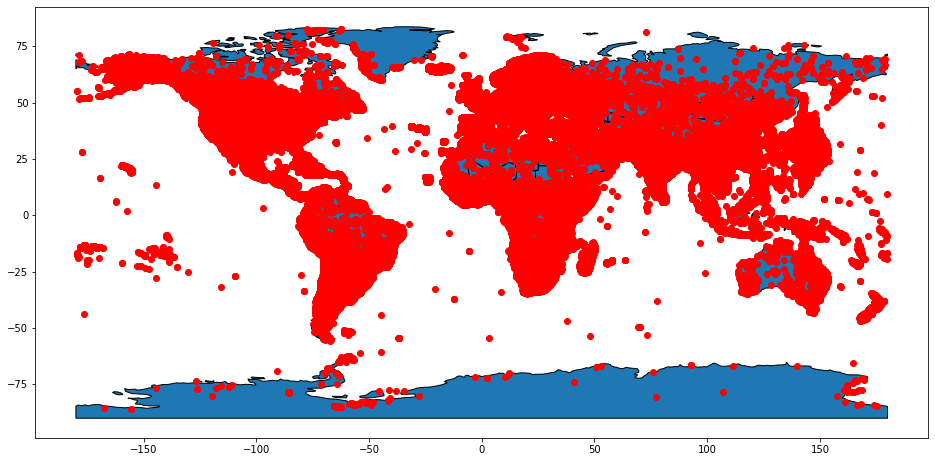

In [29]:
gdf = geopandas.GeoDataFrame(
dfx2, geometry=geopandas.points_from_xy(dfx2.longitude, dfx2.latitude,dfx2.index))


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world.plot(
    edgecolor='black',figsize=(16,16))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax,color='red')

plt.show()

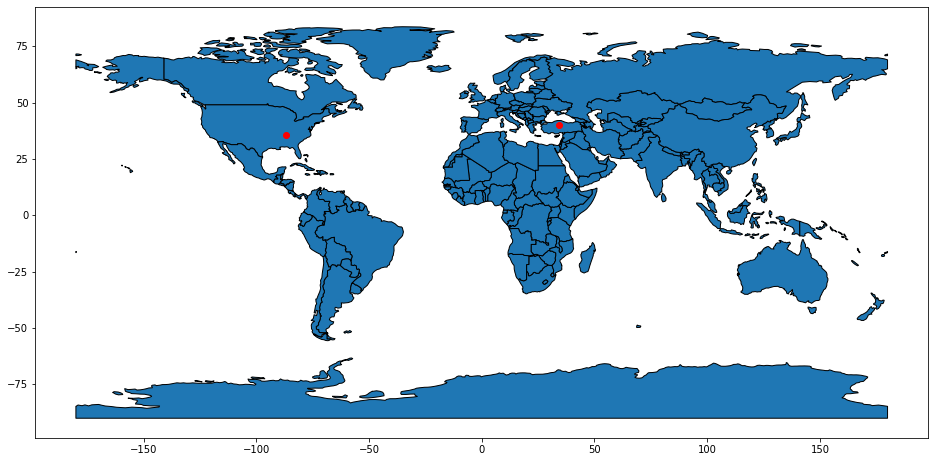

In [30]:
gdf = geopandas.GeoDataFrame(
    dfxc, geometry=geopandas.points_from_xy(dfxc.longitude, dfxc.latitude))


world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world.plot(
    edgecolor='black',figsize=(16,16))

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax,color='red')

plt.show()

In [36]:
dist1=[];
for i in range(3,30):
    n_clusters=i
    distance="greatcircle"
    iterations=5
    convergedistance=0.01
    ic=rddlatlon.map(lambda x:(x[1],x[2])).takeSample(False, n_clusters);
    outputfile=[];
    outputfile.extend(ic);

    for i in range(0,iterations):
        if(distance=="euclidean"):
            rddce=rddlatlon.map(lambda x:(x[0],x[1],x[2],[euclideanDistance(x[1],x[2],ic[z][0],ic[z][1]) for z in range(0,n_clusters)],np.argmin([euclideanDistance(x[1],x[2],ic[j][0],ic[j][1]) for j in range(n_clusters)])))
            rdddist=rddlatlon.map(lambda x:(np.argmin([euclideanDistance(x[1],x[2],ic[j][0],ic[j][1]) for j in range(0,n_clusters)]),(x[1],x[2])))
        elif(distance=="greatcircle"):
            rddce=rddlatlon.map(lambda x:(x[0],x[1],x[2],[greatcircle(x[1],x[2],ic[z][0],ic[z][1]) for z in range(0,n_clusters)],np.argmin([greatcircle(x[1],x[2],ic[j][0],ic[j][1]) for j in range(n_clusters)])))
            rdddist=rddlatlon.map(lambda x:(np.argmin([greatcircle(x[1],x[2],ic[j][0],ic[j][1]) for j in range(0,n_clusters)]),(x[1],x[2])))
        rddist=rdddist.groupByKey().map(lambda x:(mean([k[0] for k in x[1]]),mean([k[1] for k in x[1]]))) 
        old=ic;
        new=rddist.collect();
        if(len(new)<n_clusters):
            diff=(n_clusters-len(new));
            exclus=rddlatlon.map(lambda x:(x[1],x[2])).takeSample(False,diff);
            new.extend(exclus)
        dist=sum(centroidDistance(old,new))
        if(dist<=convergedistance or checkEquality(old,new)):
            print(dist)
            break;
        else:
            ic=new;
            outputfile.extend(ic)
            print(ic)
    dist1.append(dist)
        
        
        


[(40.24679927352817, 33.94682219462009), (16.19085000760731, -74.35056650436583), (41.64622274842214, -90.49187935640556)]
[(40.252735637645465, 33.67054398763844), (40.09450182480511, -87.96209293220122), (-3.2735248159746995, -60.44849000888504)]
[(40.27647669683785, 34.01612796584768), (-15.66325755474072, -43.98031055341327), (39.52714023550087, -89.26219381271406)]
[(40.73973931920525, 33.779041482069964), (39.08487610726614, -88.60859920687464), (-20.45165805082723, -21.371787721323354)]
[(41.282659810251864, 34.04284038229345), (-17.610465570767143, -8.625605069259736), (38.66904663912605, -88.52990736544753)]
[(26.96721119057243, 69.71895980034127), (35.236581539794905, -86.9474447350996), (46.60335100762753, 2.196217354369078), (50.58641759590099, 17.26245573762181)]
[(46.188056108279966, 1.681137190190969), (26.09065716166887, 72.44522322972978), (49.28826370374671, 20.42753666905803), (35.756406327133924, -88.21433640757304)]
[(46.34445720716284, 1.725521470791449), (48.0663

In [37]:
dist1

[188.1158900885087,
 240.826325910528,
 218.68694782365938,
 316.67679268880124,
 383.93287920297576,
 526.6828687662804,
 627.8048996048781,
 454.6510614144302,
 847.9872536877151,
 902.156488851988,
 1202.461674966781,
 941.3960179900319,
 1084.9298743930758,
 1435.6371924196812,
 1339.626571735581,
 1043.913401343148,
 1547.5724807194692,
 1466.6358821618705,
 1102.833476156739,
 1202.3946673693572,
 1723.9323014960326,
 1803.9651357042221,
 2038.8242804938552,
 2033.6802703981825,
 2210.980786815731,
 1689.008205139989,
 2444.007982184377]

In [42]:
x=[i for i in range(3,30)]

In [43]:
x

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29]

In [45]:
dist1

[188.1158900885087,
 240.826325910528,
 218.68694782365938,
 316.67679268880124,
 383.93287920297576,
 526.6828687662804,
 627.8048996048781,
 454.6510614144302,
 847.9872536877151,
 902.156488851988,
 1202.461674966781,
 941.3960179900319,
 1084.9298743930758,
 1435.6371924196812,
 1339.626571735581,
 1043.913401343148,
 1547.5724807194692,
 1466.6358821618705,
 1102.833476156739,
 1202.3946673693572,
 1723.9323014960326,
 1803.9651357042221,
 2038.8242804938552,
 2033.6802703981825,
 2210.980786815731,
 1689.008205139989,
 2444.007982184377]

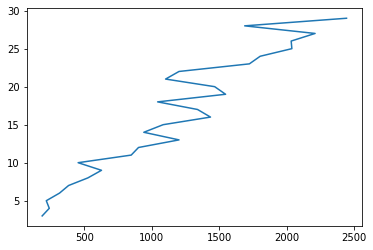

In [60]:
plt.plot(dist1,x)

In [50]:
x.reverse()

In [55]:
x

[29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3]

In [58]:
dist1.reverse()

In [59]:
dist1

[2444.007982184377,
 1689.008205139989,
 2210.980786815731,
 2033.6802703981825,
 2038.8242804938552,
 1803.9651357042221,
 1723.9323014960326,
 1202.3946673693572,
 1102.833476156739,
 1466.6358821618705,
 1547.5724807194692,
 1043.913401343148,
 1339.626571735581,
 1435.6371924196812,
 1084.9298743930758,
 941.3960179900319,
 1202.461674966781,
 902.156488851988,
 847.9872536877151,
 454.6510614144302,
 627.8048996048781,
 526.6828687662804,
 383.93287920297576,
 316.67679268880124,
 218.68694782365938,
 240.826325910528,
 188.1158900885087]